# Neural Network Image Classification
110062802 呂宸漢

## Data Loader
由於這次的訓練資料與測試資料都是圖片，而且都為黑白的圖片，因此我使用`OpenCV`中的`imread`搭配`cv2.IMREAD_GRAYSCALE`讀取圖片，圖片資料的shape為32x32x1，在讀取完畢後我會將圖片資料拉成一維並儲存。而圖片的label我則是直接儲存成數字，如：0, 1, 2類。

In [1]:
import os, glob
import numpy as np
import cv2

def data_loader(filepath: str) -> tuple[np.ndarray, np.ndarray]:
    data_list = []
    label_list = []
    class_folder_list = ['Carambula', 'Lychee', 'Pear']
    for i, class_folder in enumerate(class_folder_list):
        img_path_list = glob.glob(os.path.join(filepath, class_folder, '*.png'))
        data = np.zeros((len(img_path_list), 32 * 32), dtype=int)
        label = np.zeros((len(img_path_list),), dtype=int)
        for j, img_path in enumerate(img_path_list):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            data[j] = np.array(img).flatten()
            label[j] = i
        data_list.append(data)
        label_list.append(label)
    
    data_array = np.concatenate(data_list)
    label_array = np.concatenate(label_list)
    return data_array, label_array

train_data_array, train_label_array = data_loader('./Data/Data_train')
test_data_array, test_label_array = data_loader('./Data/Data_test')

## Feature Extraction
依照題目要求，我們必須利用Principal Components Analysis (PCA)將原本的圖片資料降到二維，也就是從1024維降到二維。由於PCA容易被資料的scale影響，因此在降維之前我們必須先將資料標準化，這裡我利用`scikit-learn`中的`StandardScaler`將資料標準化，再利用`scikit-learn`中的`PCA`降維。`StandardScaler`與`PCA`的使用方式很簡單，在建構物件時需先設定好參數，如要利用`PCA`將資料降成二維，則可以將`PCA`的`n_components`設成2即可，建完物件後便可以用`fit`將物件內部的參數fit training data，再利用`transform`轉換training data與testing data即可。

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_data_array)

train_data_array = scaler.transform(train_data_array)
test_data_array = scaler.transform(test_data_array)

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pca.fit(train_data_array)

train_features = pca.transform(train_data_array)
test_features = pca.transform(test_data_array)

X_train, y_train = train_features, train_label_array
X_test, y_test = test_features, test_label_array

# A. Two-layer Neural Network
### Forwarding flow:
input data $\rightarrow$ concate with bias0 $\rightarrow$ multiply with weight0 $\rightarrow$ batch normalization $\rightarrow$ sigmoid $\rightarrow$ multiply with weight1 and add bias1 $\rightarrow$ softmax

## 1. Neural network architecture
這次作業是要實作一個neural network以解決image classification的問題，如spec所述，我們要分別實作兩層與三層的neural network，input layer與output layer的node數都為三個，而hidden layer的node數則可以自己決定。由於分別實作兩層與三層的neural network在實作時會有很多相似的code，只有weight數量、forward與backward會有些不同，因此我決定直接實作一個general的neural network，可以透過參數調整hidden layer的層數與neuron數量，並在操作上仿照`scikit-learn`的`MLPClassifier`，可以在建立物件後直接使用`fit`與`predict`做training與prediction，讓操作更簡潔。以下我會分別介紹我實作的neural network可以設定的parameter、各個member function的功能與實作細節：
### Parameter:
* `hidden_layer_sizes`: 為一個`tuple`，可自行設定hidden layer層數及每一層的neuron數，如`(100,)`代表只有一層hidden layer且那一層有100個neuron，而`(100, 150)`代表有兩層hidden layer且第一層與第二層的neuron數分別為100與150。
* `batch_size`: 由於這次作業是要實作Stochastic Gradient Descent (SGD)，必須先將資料分成一個一個batch，一次提取一個batch的資料做forwarding並計算平均的loss，再用loss計算gradient以更新weight，而這個`batch_size`就是設定一次用幾筆data計算loss的batch大小。
* `epoch`: 設定training的epoch數，當所有batch的資料都有被拿來訓練過，則完成一個epoch。因此一個epoch會跑的batch數為training sample數除以`batch_size`，無法除盡的data則在此epoch中被drop掉，下個epoch再加進來進行batch分配。
* `learning_rate`: 也就是SGD中更新weight時的learning rate。
* `random_seed`: 因為在實作過程中會用到`np.random`，會導致每次執行的結果不同，因此會使用此`random_seed`給定一個固定的seed使結果為deterministic。
* `verbose`: 當`verbose`為`True`時會印出training時每個epoch的loss與accuracy；反之，為`False`時則不會顯示training訊息。
### Member function (protected):
* `_initialize`: 建立所需的內部變數與初始化weight及bias，weight及bias的初始數值都由random產生。
* `_batch_norm`: 因為此次作業的spec要求hidden layer的activation function要是sigmoid，但是activation若不經過處理直接進入sigmoid容易進到sigmoid的飽和區間，為了避免此情況必須先利用此function將activation標準化，再餵進sigmoid內，以避免sigmoid容易進入飽和區的問題。
* `_batch_norm_derivative`: batch normalization的導數。
* `_sigmoid`: hidden layer的activation function。
* `_sigmoid_derivative`: sigmoid的導數。
* `_softmax`: output layer的activation function，主要是將數值mapping到[0, 1]。
* `_cross_entropy`: 計算gradient所需loss的loss function。
* `_softmax_and_cross_entropy_derivative`: softmax與cross entropy的導數。
* `_accuracy_score`: 計算prediction的accuracy。
* `_forward_pass`: 為forward process，將input data forward進整個neural network中，在training與prediction都會用到。
    1. layer 1 計算方式：

        $Z^{(0)} = X \operatorname{concate} bias^{(0)}$

        $a_j^{(1)} = \sum_{i=1}^{D^{(0)}}{w_{ji}^{(0)}z_i^{(0)}} \rightarrow z_j^{(1)} = \sigma(a_j^{(1)}) = \frac{1}{1 + e^{-a_j^{(1)}}}$

    2. layer 2 ... K-1 計算方式：
    
        $a_j^{(k)} = \sum_{i=1}^{D^{(k-1)}}{w_{ji}^{(k-1)}z_i^{(k-1)}+bias^{(k-1)}} \rightarrow z_j^{(k)} = \sigma(a_j^{(k)}) = \frac{1}{1 + e^{-a_j^{(k)}}}$
        
    3. layer K 計算方式：

        $a_j^{(K)} = \sum_{i=1}^{D^{(K-1)}}{w_{ji}^{(K-1)}z_i^{(K-1)}+bias^{(K-1)}} \rightarrow z_j^{(K)} = \operatorname{softmax}(a_j^{(K)})$

* `_backprop`: 為back-propagation，利用forward後得到的loss計算gradient，並更新對應的weight與bias。計算gradient可以透過計算一些$\delta$數值達成，再搭配chain rule即可計算每個weight的gradient並修正weight，計算方式如下：
    1. layer K 的$\delta$計算方式：

        $\delta_{a^{(K)}} = \frac{\partial{L}}{\partial{a^{(K)}}} = z^{(K)} - y$

    2. layer K-1 ... 1 的$\delta$計算方式：

        $\delta_{a^{(k)}} = \frac{\partial{L}}{\partial{a^{(k)}}} = \frac{\partial{L}}{\partial{a^{(k+1)}}}\frac{\partial{a^{(k+1)}}}{\partial{z^{(k)}}}\frac{\partial{z^{(k)}}}{\partial{a^{(k)}}} = \delta_{a^{(k+1)}}w^{(k)}\frac{\partial{z^{(k)}}}{\partial{a^{(k)}}}$

    3. weight 更新方式 ($k$ = 0 ... K-1)：

        $\frac{\partial{L}}{\partial{w^{(k)}}} = \frac{\partial{L}}{\partial{a^{(k+1)}}}\frac{\partial{a^{(k+1)}}}{\partial{w^{(k)}}} = \delta_{a^{(k+1)}}z^{(k)}$

        $w^{(k)} = w^{(k)} - \eta\frac{\partial{L}}{\partial{w^{(k)}}}$

### Member function (public):
* `fit(X, y)`: 為training process，會先shuffle training data再依照`batch_size`切成不同batch，一次將一個batch的data餵進`_forward_pass`計算loss，並用`_backprop`更新weight，在一個epoch結束後紀錄該epoch的loss並重新shuffle training data以產生下一個epoch所需的batch，再利用forward與back-propagation更新weight直到到達指定epoch數。
* `predict(X)`: 將data餵進`_forward_pass`預測各個類別的機率，再利用`np.argmax`以轉換成預測類別的index。
* `predict_proba(X)`: 將data餵進`_forward_pass`預測各個類別的機率。

In [4]:
import numpy as np

class NeuralNetwork:
    def __init__(
        self,
        hidden_layer_sizes: tuple = (100,),
        batch_size: int = 128,
        epoch: int = 100,
        learning_rate: float = 1e-3,
        random_seed: int = None,
        verbose: bool = False
        ) -> None:
        if isinstance(hidden_layer_sizes, int):
            self.hidden_layer_sizes = [hidden_layer_sizes]
        elif isinstance(hidden_layer_sizes, tuple):
            self.hidden_layer_sizes = list(hidden_layer_sizes)
        self.batch_size = batch_size
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.random_seed = random_seed
        self.verbose = verbose
        self.CONST = 1e-9
    
    def _initialize(self, layer_units: list) -> None:
        self.n_layer = len(layer_units)
        self.warm_up = True
        self.batch_param = {}
        self.weight = {}
        self.bias = {}

        self.weight[0] = np.random.rand(layer_units[0] + 1, layer_units[1])
        for i in range(1, self.n_layer - 1):
            self.batch_param[i] = (np.zeros((layer_units[i],)), np.zeros((layer_units[i],)))
            self.weight[i] = np.random.rand(layer_units[i], layer_units[i + 1])
            self.bias[i] = np.random.rand(1, layer_units[i + 1])
        
        self.loss_curve = []
    
    def _batch_norm(self, X: np.ndarray, layer_idx: int, trainable: bool = False) -> np.ndarray:
        if trainable:
            mean, std = np.mean(X, axis=0), np.std(X, axis=0)
            if self.warm_up:
                self.batch_param[layer_idx] = (mean, std)
            else:
                self.batch_param[layer_idx] = (self.batch_param[layer_idx][0] * 0.9 + mean * 0.1, 
                                               self.batch_param[layer_idx][1] * 0.9 + std * 0.1)
        else:
            mean, std = self.batch_param[layer_idx]
        return (X - mean) / (std + self.CONST)

    def _batch_norm_derivative(self, X: np.ndarray) -> np.ndarray:
        return 1.0 / (np.std(X, axis=0) + self.CONST)
    
    def _sigmoid(self, X: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-X))
    
    def _sigmoid_derivative(self, X: np.ndarray) -> np.ndarray:
        return X * (1.0 - X)

    def _softmax(self, X: np.ndarray) -> np.ndarray:
        return np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)
    
    def _cross_entropy(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return np.sum(-y_true * np.log(y_pred + self.CONST), axis=1)

    def _softmax_and_cross_entropy_derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return y_pred - y_true
    
    def _accuracy_score(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        if y_true.ndim == 2:
            y_true = np.argmax(y_true, axis=1)
        if y_pred.ndim == 2:
            y_pred = np.argmax(y_pred, axis=1)
        return float(np.sum([y_true == y_pred]) / y_true.shape[0])

    def _forward_pass(self, X: np.ndarray, trainable: bool = False) -> tuple[np.ndarray, dict, dict]:
        z, a = {}, {}
        bias0 = np.ones((X.shape[0], 1))
        z[0] = np.concatenate([X, bias0], axis=1)
        a[1] = z[0] @ self.weight[0]

        for i in range(1, self.n_layer - 1):
            norm = self._batch_norm(a[i], i, trainable=trainable)
            z[i] = self._sigmoid(norm)
            a[i + 1] = z[i] @ self.weight[i] + self.bias[i]

        out = self._softmax(a[self.n_layer - 1])
        return out, a, z

    def _backprop(self, X: np.ndarray, y: np.ndarray) -> tuple[float, float]:
        out, a, z = self._forward_pass(X, trainable=True)
        self.warm_up = False

        d_a = {}
        d_a[self.n_layer - 1] = self._softmax_and_cross_entropy_derivative(y, out)
        for i in range(self.n_layer - 2, 0, -1):
            d_a[i] = d_a[i + 1] @ self.weight[i].T * self._sigmoid_derivative(z[i]) * self._batch_norm_derivative(a[i])
        
        for i in range(1, self.n_layer - 1):
            delta_bias = np.ones((z[i - 1].shape[0], 1)).T @ d_a[i + 1]
            self.bias[i] -= self.learning_rate * delta_bias

        for i in range(self.n_layer - 1):
            delta_weight = z[i].T @ d_a[i + 1]
            self.weight[i] -= self.learning_rate * delta_weight

        loss = self._cross_entropy(y, out)
        loss = np.mean(loss)
        accuracy = self._accuracy_score(y, out)
        return loss, accuracy

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        np.random.seed(self.random_seed)
        self.output_dim = y.ndim
        if self.output_dim == 1:
            y = np.eye(len(np.unique(y)), dtype=int)[y]

        n_samples, n_features = X.shape
        self.n_outputs = y.shape[1]
        layer_units = [n_features] + self.hidden_layer_sizes + [self.n_outputs]
        self._initialize(layer_units)

        indices = np.arange(n_samples)
        max_iter = n_samples // self.batch_size
        for i in range(self.epoch):
            np.random.shuffle(indices)
            accumulated_loss = 0
            accumulated_accuracy = 0
            for j in range(max_iter):
                idx = indices[j * self.batch_size:(j + 1) * self.batch_size]
                batch_loss, batch_accuracy = self._backprop(X[idx], y[idx])
                accumulated_loss += batch_loss
                accumulated_accuracy += batch_accuracy

            self.loss = accumulated_loss / max_iter
            self.loss_curve.append(self.loss)
            self.accuracy = accumulated_accuracy / max_iter
            if self.verbose:
                print(f'Epoch {i:d}, training loss = {self.loss:f}, accuracy = {self.accuracy:f}')

    def predict(self, X: np.ndarray) -> np.ndarray:
        np.random.seed(self.random_seed)
        y_pred_prob = self._forward_pass(X)[0]
        y_pred = np.argmax(y_pred_prob, axis=1)
        if self.output_dim == 2:
            y_pred = np.eye(self.n_outputs, dtype=int)[y_pred]
        return y_pred
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        np.random.seed(self.random_seed)
        y_pred_prob = self._forward_pass(X)[0]
        return y_pred_prob

## 2. Training and testing accuray
由測試結果可以看出，用我的model去預測的testing accuracy比training accuracy還要好，我認為是因為testing data在PCA取feature後的分布較好，因此model較容易預測結果。為了驗證這不是只有我的model會有的問題，我也有使用`scikit-learn`中的`MLPClassifier`測試，也是一樣的結果，因此可以推測是feature的問題。

In [5]:
from sklearn.metrics import accuracy_score

nn2 = NeuralNetwork(random_seed=0)
nn2.fit(X_train, y_train)

print('Accuracy of my 2-layer neural network:')
y_pred = nn2.predict(X_train)
print(f'Training accuracy: {accuracy_score(y_train, y_pred):f}')

y_pred = nn2.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred):f}')

Accuracy of my 2-layer neural network:
Training accuracy: 0.850340
Testing accuracy: 0.953815


In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train, y_train)

print('Accuracy of scikit-learn\'s MLPClassifier:')
y_pred = mlp.predict(X_train)
print(f'Training accuracy: {accuracy_score(y_train, y_pred):f}')

y_pred = mlp.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred):f}')

Accuracy of scikit-learn's MLPClassifier:
Training accuracy: 0.915646
Testing accuracy: 0.981928


## 3. Plot training loss curve
因為我的model在training時有將每個epoch的training loss紀錄在`loss_curve`裡，因此只要將model的`loss_curve`的值取出並畫出來即可，由此圖可以看出我的model大概在30個epoch後loss的下降幅度微乎其微，往後的epoch只有慢慢下降而已。

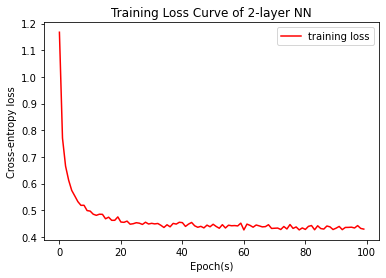

In [7]:
import matplotlib.pyplot as plt

def plot_training_loss_curve(clf: NeuralNetwork) -> None:
    plt.plot(clf.loss_curve, 'r-', label='training loss')
    plt.title(f'Training Loss Curve of {clf.n_layer - 1}-layer NN')
    plt.xlabel('Epoch(s)')
    plt.ylabel('Cross-entropy loss')
    plt.legend()
    plt.show()

plot_training_loss_curve(nn2)

## 4. Plot decision boundary
這裡我畫出model在predict training data時的decision boundary，也就是將training data投影到二維平面，再畫出model在二維平面中的每個點會predict的結果即可畫出decision boundary，最後再將training data的資料點貼上去即可看出分類結果好壞。

以下是我畫decision boundary的流程：
1. 先用我的model predict training data以獲得預測結果。
2. 將training data做standard scale在餵進`PCA`以轉成二維資料(雖然本來就是二維了)。
3. 以二維的資料當作feature並用predict的結果當作label去train KNN。
4. 取出二維資料的資料範圍並建立成mesh grid，在將mesh grid餵進KNN去predict每個座標點的類別，即可得到decision boundary的顏色(用類別區分)。
5. 畫出decision boundary並加上training data的座標點，而training data的顏色就用實際的類別去區分即可。

由下圖可以看出，在training set中有三個類別混和在一起無法輕易分開，較難找到一個boundary可以將其分離，這也說明為什麼無論是我的model或是`scikit-learn`中的`MLPClassifier`都無法在training data有較好的成功率。而在testing set中三個類別都很分散，因此無論在我的model或是`scikit-learn`中的`MLPClassifier`都預測的較好，有較高的accuracy。

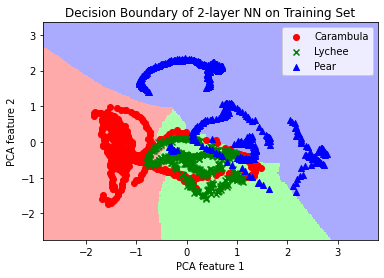

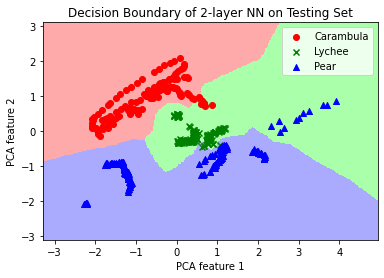

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_boundary(clf: NeuralNetwork, X: np.ndarray, y: np.ndarray, title: str) -> None:
    y_pred = clf.predict(X)
    y_true = y
    
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)

    pca = PCA(n_components=2, random_state=0)
    pca.fit(X)
    X = pca.transform(X)

    knn = KNeighborsClassifier()
    knn.fit(X, y_pred)

    x_min, y_min = np.min(X, axis=0) - 1
    x_max, y_max = np.max(X, axis=0) + 1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250), np.linspace(y_min, y_max, 250))
    color_label = knn.predict(np.c_[xx.flatten(), yy.flatten()]).reshape(xx.shape)

    labels = [0, 1, 2]
    colors = ['r', 'g', 'b']
    markers = ['o', 'x', '^']
    names = ['Carambula', 'Lychee', 'Pear']
    cmap = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

    plt.figure()
    plt.pcolormesh(xx, yy, color_label, cmap=cmap)
    for label, color, marker, name in zip(labels, colors, markers, names):
        plt.scatter(X[label==y_true, 0], X[label==y_true, 1], c=color, marker=marker, label=name)
    plt.title(f'Decision Boundary of {clf.n_layer - 1}-layer NN on {title} Set')
    plt.xlabel('PCA feature 1')
    plt.ylabel('PCA feature 2')
    plt.legend(loc='upper right')
    plt.show()

plot_decision_boundary(nn2, X_train, y_train, 'Training')
plot_decision_boundary(nn2, X_test, y_test, 'Testing')

## 5. Discussion
以下我分別比較不同`batch_size`設定、不同`learning_rate`設定與不同`hidden_layer_sizes`設定對training loss的影響。

### i. 不同`batch_size`大小對training loss的影響
由下圖可以看出不同`batch_size`對loss的收斂速度沒有影響，不過大概在第10個epoch後開始有明顯的區別，`batch_size`較小時loss收斂在較大的值，而且loss的變動也較大，而`batch_size`較大時loss則收斂在較小的值，loss的變動也較平穩。這主要是因為我們使用SGD計算gradient，當`batch_size`較小時每一次抓進來算loss的資料較少，不同batch間的loss差異較大，因此訓練時loss的震盪也較大，不過因為隨機性較大，因此訓練出來的model的泛化性較好；反之，當`batch_size`較大時每一次抓進來算loss的資料較多，不同batch間的loss差異較小，因此訓練時loss的震盪也較小，因為gradient較平穩，有利於model訓練，所以loss較低。

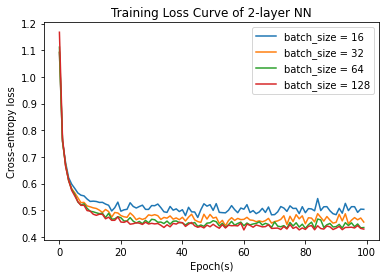

In [9]:
import matplotlib.pyplot as plt

def plot_batch_size_comparison(X: np.ndarray, y: np.ndarray, hidden_layer_sizes: tuple) -> None:
    for i in range(4, 8):
        batch_size = 2 ** i
        nn = NeuralNetwork(random_seed=0, hidden_layer_sizes=hidden_layer_sizes, batch_size=batch_size)
        nn.fit(X, y)
        plt.plot(nn.loss_curve, label=f'batch_size = {batch_size}')
    plt.title(f'Training Loss Curve of {nn.n_layer - 1}-layer NN')
    plt.xlabel('Epoch(s)')
    plt.ylabel('Cross-entropy loss')
    plt.legend()
    plt.show()

plot_batch_size_comparison(X_train, y_train, (100,))

### ii. 不同`learning_rate`大小對training loss的影響
由下圖可以看出不同`learning_rate`對loss的收斂程度有很大的影響，當`learning_rate`較大時gradient更新的step較大，也就是一次可以走比較大步，雖然在初期的訓練可以增加model收斂速度，不過一直維持這種步伐會導致model較難收斂到低點，反而會在低點附近一直震盪，以致於training loss雖然很快就收斂，可是收斂的值會很差；而較大的`learning_rate` gradient更新的step較小，也就是一次走一小步，雖然model收斂的速度較慢，但是loss下降的會較穩定，不過步伐較小也可能會導致model卡在local minimum，因此，目前主流的neural network都會自己調整`learning_rate`，較少使用固定的值。

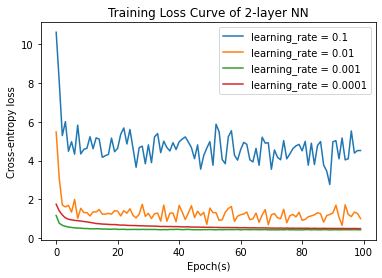

In [10]:
import matplotlib.pyplot as plt

def plot_learning_rate_comparison(X: np.ndarray, y: np.ndarray, hidden_layer_sizes: tuple) -> None:
    for i in range(1, 5):
        learning_rate = 10 ** (-i)
        nn = NeuralNetwork(random_seed=0, hidden_layer_sizes=hidden_layer_sizes, learning_rate=learning_rate)
        nn.fit(X, y)
        plt.plot(nn.loss_curve, label=f'learning_rate = {learning_rate}')
    plt.title(f'Training Loss Curve of {nn.n_layer - 1}-layer NN')
    plt.xlabel('Epoch(s)')
    plt.ylabel('Cross-entropy loss')
    plt.legend()
    plt.show()

plot_learning_rate_comparison(X_train, y_train, (100,))

### iii. 不同`hidden_layer_sizes`大小對training loss的影響
由下圖可以看出不同`hidden_layer_sizes`對loss的收斂速度有很大的影響，當`hidden_layer_sizes`較小時loss下降得較平緩且也較穩定，而當`hidden_layer_sizes`較大時loss下降得較快但震盪較大。我推測是因為不同的`hidden_layer_sizes`直接影響model的複雜度，`hidden_layer_sizes`較小也就是較簡單的model需要較長的時間才能fit training data；而`hidden_layer_sizes`較大也就是較複雜的model可以較快fit training data。

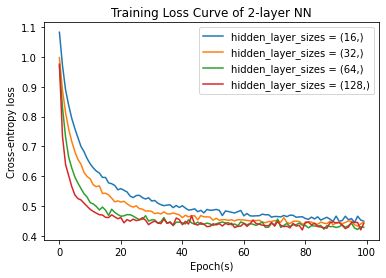

In [11]:
import matplotlib.pyplot as plt

def plot_hidden_layer_sizes_comparison(X: np.ndarray, y: np.ndarray, hidden_layer_num: int) -> None:
    for i in range(4, 8):
        hidden_layer_sizes = (2 ** i,) * hidden_layer_num
        nn = NeuralNetwork(random_seed=0, hidden_layer_sizes=hidden_layer_sizes)
        nn.fit(X, y)
        plt.plot(nn.loss_curve, label=f'hidden_layer_sizes = {hidden_layer_sizes}')
    plt.title(f'Training Loss Curve of {nn.n_layer - 1}-layer NN')
    plt.xlabel('Epoch(s)')
    plt.ylabel('Cross-entropy loss')
    plt.legend()
    plt.show()

plot_hidden_layer_sizes_comparison(X_train, y_train, 1)

# B. Three-layer Neural Network
### Forwarding flow:
input data $\rightarrow$ concate with bias0 $\rightarrow$ multiply with weight0 $\rightarrow$ batch normalization $\rightarrow$ sigmoid $\rightarrow$ multiply with weight1 and add bias1 $\rightarrow$ batch normalization $\rightarrow$ sigmoid $\rightarrow$ multiply with weight2 and add bias2 $\rightarrow$ softmax

## 1. Neural network architecture
如同Part A的neural network architecture所述，因為前面實作的neural network架構是general的neural network，因此我們只需要將`NeuralNetwork`內的`hidden_layer_sizes`參數設成(100, 100)並創建物件，即可得到兩層hidden layer的neuron數皆為100的3-layer neural network。

## 2. Training and testing accuray
3-layer neural network的accuracy result與2-layer neural network的accuracy result大同小異，一樣都是testing accuracy比training accuracy好。而且多一個layer對我的model的prediction accuracy影響不大，training accuracy比2-layer低一些，而testing accuracy比2-layer高一些，不過差異並不大，我認為是因為我們的input feature不複雜，可能兩個layer就夠了。而以`scikit-learn`的`MLPClassifier`而言，他的training accuracy與2-layer相同，不過testing accuracy有稍微下降一點點。

In [12]:
from sklearn.metrics import accuracy_score

nn3 = NeuralNetwork(random_seed=0, hidden_layer_sizes=(100, 100))
nn3.fit(X_train, y_train)

print('Accuracy of my 2-layer neural network:')
y_pred = nn3.predict(X_train)
print(f'Training accuracy: {accuracy_score(y_train, y_pred):f}')

y_pred = nn3.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred):f}')

Accuracy of my 2-layer neural network:
Training accuracy: 0.840816
Testing accuracy: 0.967871


In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(max_iter=1000, random_state=0, hidden_layer_sizes=(100, 100))
mlp.fit(X_train, y_train)

print('Accuracy of scikit-learn\'s MLPClassifier:')
y_pred = mlp.predict(X_train)
print(f'Training accuracy: {accuracy_score(y_train, y_pred):f}')

y_pred = mlp.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred):f}')

Accuracy of scikit-learn's MLPClassifier:
Training accuracy: 0.918367
Testing accuracy: 0.977912


## 3. Plot training loss curve
由下圖可以看出3-layer neural network的training loss收斂速度較2-layer neural network的training loss收斂速度緩慢，大概要90個epoch才趨於收斂，而且最終的training loss的數值比2-layer neural network的training loss還要大一些。

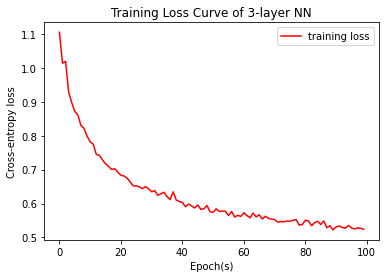

In [14]:
plot_training_loss_curve(nn3)

## 4. Plot decision boundary
由下圖可以看出，在training set中，3-layer neural network的decision boundary與2-layer neural network的相似，不過有較多的紅色類別被分在綠色的地方，導致testing accuracy會比2-layer低一些；而在testing set中，3-layer neural network的decision boundary與2-layer neural network的相似，且有較多的紅色類別被分在正確的位置，所以testing accuracy有比2-layer高一些。

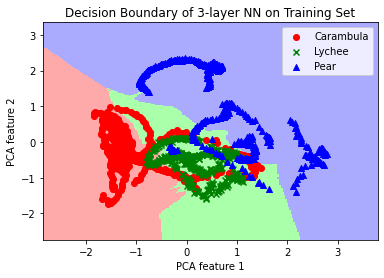

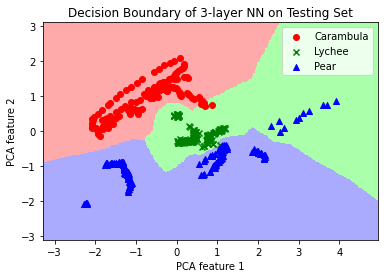

In [15]:
plot_decision_boundary(nn3, X_train, y_train, 'Training')
plot_decision_boundary(nn3, X_test, y_test, 'Testing')

## 5. Discussion
以下我分別與2-layer neural network的discussion比較不同`batch_size`設定、不同`learning_rate`設定與不同`hidden_layer_sizes`設定對training loss的影響。

### i. 不同`batch_size`大小對training loss的影響
與2-layer neural network的discussion相同[參考Part A.5.i]，不過因為要更新的weight變多，在較前面層數的gradient需要經過較多次的更新才能使loss收斂，因此與2-layer neural network相比需要較多epoch才能收斂。

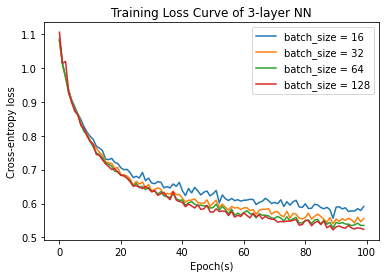

In [16]:
plot_batch_size_comparison(X_train, y_train, (100, 100))

### ii. 不同`learning_rate`大小對training loss的影響
與2-layer neural network的discussion相同[參考Part A.5.ii]，與2-layer neural network的結果無明顯差別。

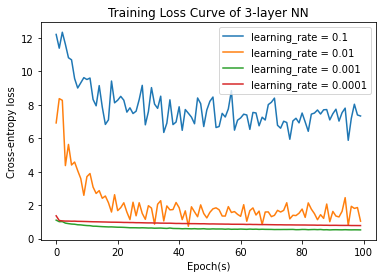

In [17]:
plot_learning_rate_comparison(X_train, y_train, (100, 100))

### iii. 不同`hidden_layer_sizes`大小對training loss的影響
與2-layer neural network的結果有些許不同，可能是因為model深度變深，需要較多個epoch才能收斂，且這次`hidden_layer_sizes`大小似乎不太影響收斂速度，由下圖可以看到四條線幾乎是重疊的，只有前幾個epoch的loss差別較大，其餘的都差不多，可能是因為layer數變多導致`hidden_layer_sizes`的影響力下降。

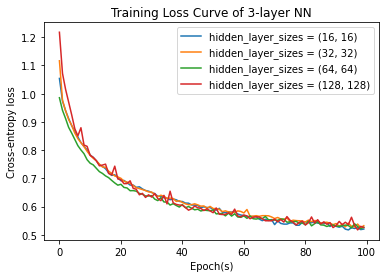

In [18]:
plot_hidden_layer_sizes_comparison(X_train, y_train, 2)